# Applying Linear Models on the Housing Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge,RANSACRegressor,HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../input/kc-house-data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


# Preprocessing

In [4]:
#see the datatype of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
#fill all the values with 0
data.fillna(0, inplace=True)

In [6]:
#iterate through the columns to see the frequency of different values
for i in data.columns:
    print(data[i].value_counts())

795000620     3
2206700215    2
643300040     2
3333002450    2
1995200200    2
             ..
3420069065    1
7812801125    1
4364700875    1
3021059276    1
1777500160    1
Name: id, Length: 21436, dtype: int64
20140623T000000    142
20140625T000000    131
20140626T000000    131
20140708T000000    127
20150427T000000    126
                  ... 
20140830T000000      1
20150110T000000      1
20150215T000000      1
20150131T000000      1
20150515T000000      1
Name: date, Length: 372, dtype: int64
450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
641500.0      1
575950.0      1
674250.0      1
608700.0      1
884744.0      1
Name: price, Length: 4028, dtype: int64
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.5

In [7]:
#format the date
d =[]
for i in data['date'].values:
    d.append(i[:4])
    
data['date'] = d

# convert everything to same datatype
for i in data.columns:
    data[i]=data[i].astype(float)
    
#make a new column age of the house  
data['age'] = data['date'] - data['yr_built']

#calculate the total years of renovation
data['renov_age'] = np.abs(data['yr_renovated'] - data['yr_built'])
data['renov_age'] = data.renov_age.apply(lambda x: x if len(str(int(x)))==2 else 0.0)

#remove unwanted columns like yr_built, date, id
data.drop(['id','date', 'yr_built', 'yr_renovated'], axis=1, inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,59.0,0.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,98125.0,47.7210,-122.319,1690.0,7639.0,63.0,40.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,82.0,0.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,98136.0,47.5208,-122.393,1360.0,5000.0,49.0,0.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0,28.0,0.0


In [8]:
#print highly correlated variables
corr_features =[]

for i , r in data.corr().iterrows():
    k=0
    for j in range(len(r)):
        if i!= r.index[k]:
            if r.values[k] >=0.5:
                corr_features.append([i, r.index[k], r.values[k]])
        k += 1
corr_features

[['price', 'bathrooms', 0.5251375054139724],
 ['price', 'sqft_living', 0.7020350546118009],
 ['price', 'grade', 0.667434256020255],
 ['price', 'sqft_above', 0.605416259164117],
 ['price', 'sqft_living15', 0.5853789035795697],
 ['bedrooms', 'bathrooms', 0.5158836376158442],
 ['bedrooms', 'sqft_living', 0.5766706925022366],
 ['bathrooms', 'price', 0.5251375054139724],
 ['bathrooms', 'bedrooms', 0.5158836376158442],
 ['bathrooms', 'sqft_living', 0.7546652789673779],
 ['bathrooms', 'floors', 0.5006531725878427],
 ['bathrooms', 'grade', 0.6649825338781631],
 ['bathrooms', 'sqft_above', 0.6852729704767384],
 ['bathrooms', 'sqft_living15', 0.5686342895782329],
 ['sqft_living', 'price', 0.7020350546118009],
 ['sqft_living', 'bedrooms', 0.5766706925022366],
 ['sqft_living', 'bathrooms', 0.7546652789673779],
 ['sqft_living', 'grade', 0.7627044764584873],
 ['sqft_living', 'sqft_above', 0.8762879508115545],
 ['sqft_living', 'sqft_living15', 0.7564202590172227],
 ['sqft_lot', 'sqft_lot15', 0.718556

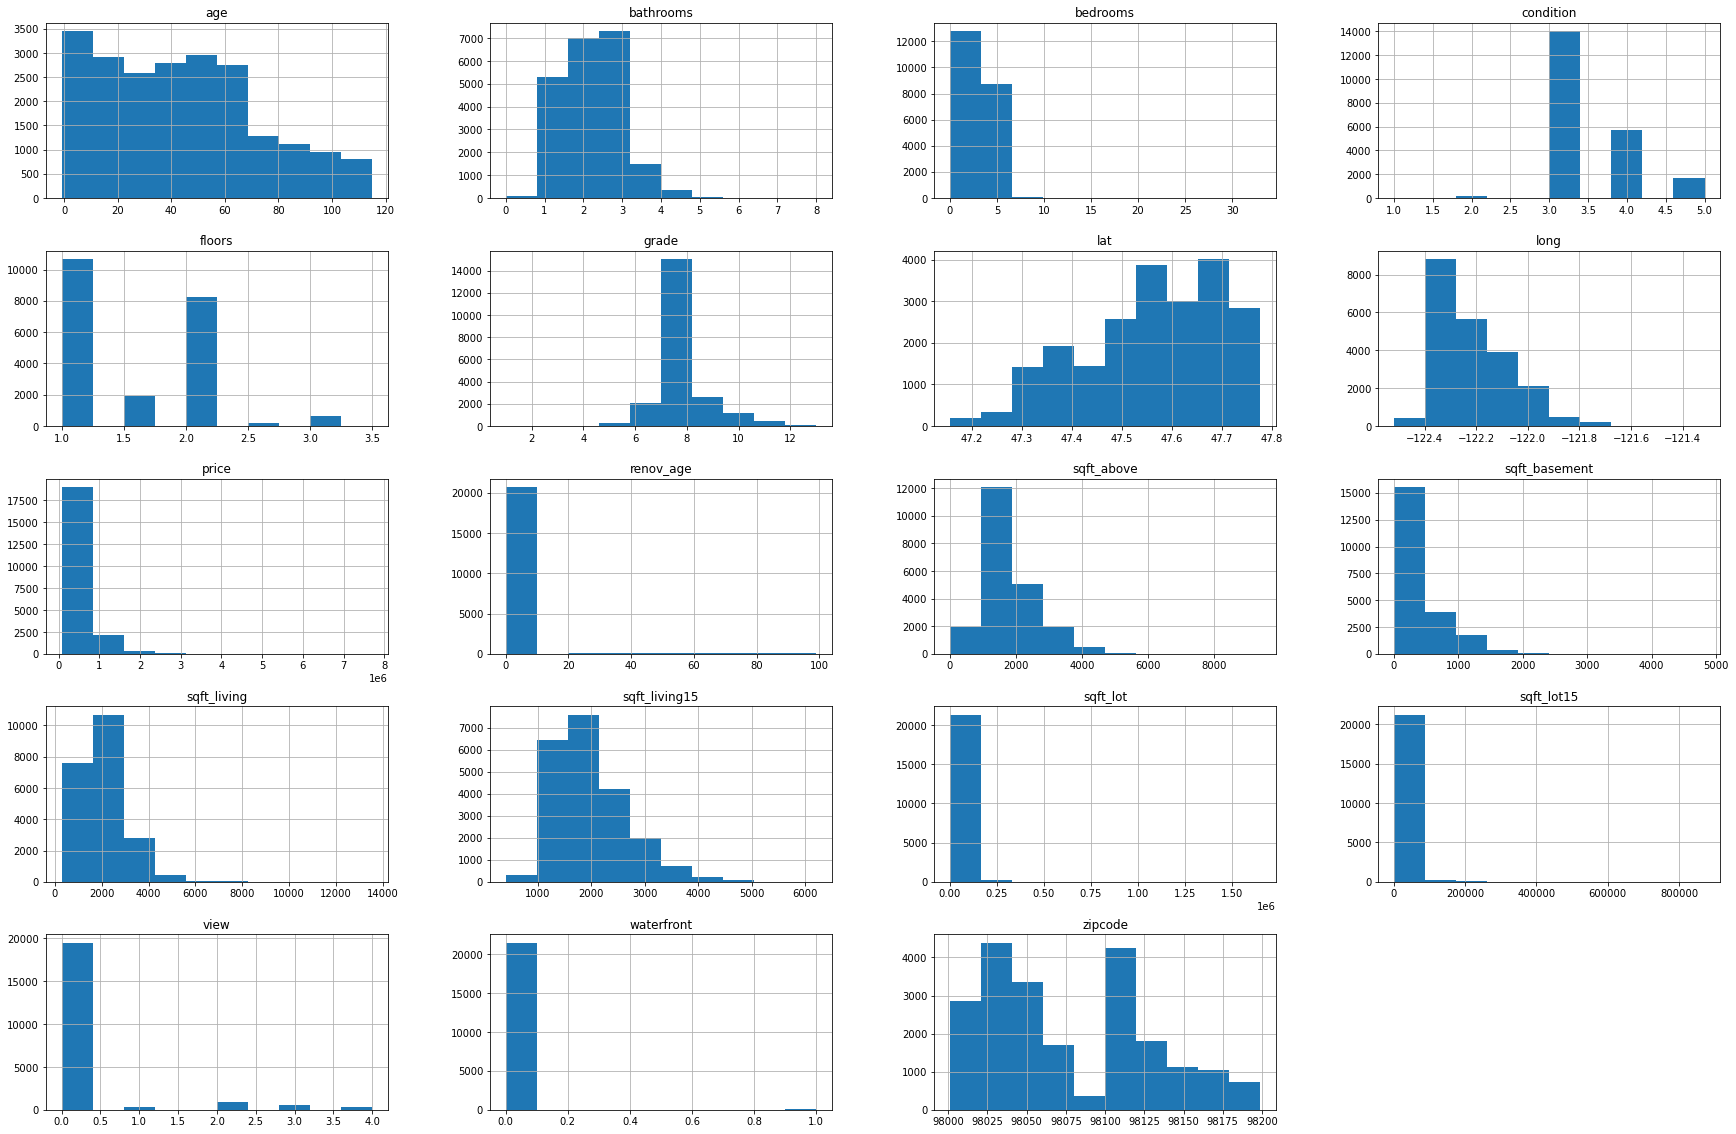

In [9]:
#plot the frequency of the columns
data.hist(figsize=(30,20))
plt.show()

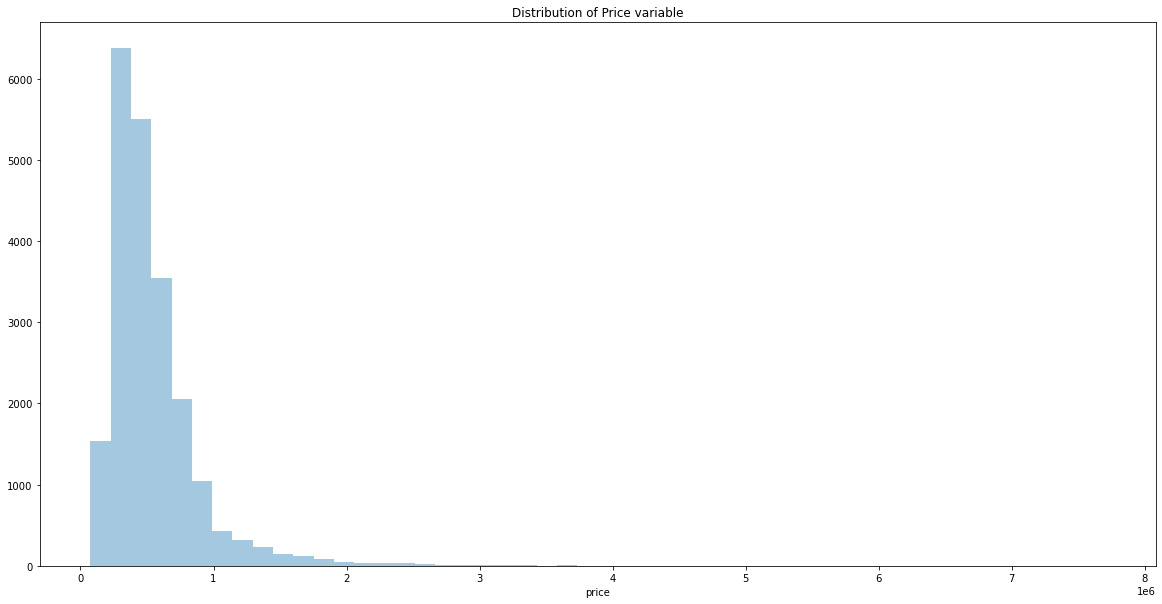

In [10]:
#let us remove highly correlated features that is above 0.8
feat =[]
for i in corr_features:
    if i[2] >= 0.8:
        feat.append(i[0])
        feat.append(i[1])
        
data.drop(list(set(feat)), axis=1, inplace=True)
data.head()

#plot the (dependent) variable to see its distribution
# plt.title()
plt.figure(figsize=(20,10))
sns.distplot(data.price, kde=False).set_title('Distribution of Price variable')
plt.show()

# outlier detection

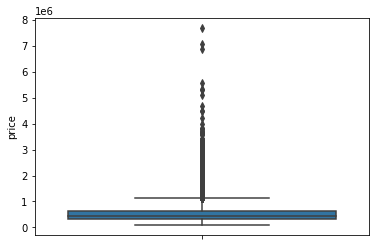

In [11]:
# creating boxplots to see the outliers in the price variable 

plt.figure(figsize=(6,4))
sns.boxplot(y=data['price']).set_title
plt.show()

In [12]:
#let us numerically draw conclusions
#creating function that can calculate interquartile range of the data
def calc_interquartile(data, column):
    global lower, upper
    #calculating the first and third quartile
    first_quartile, third_quartile = np.percentile(data[column], 25), np.percentile(data[column], 75)
    #calculate the interquartilerange
    iqr = third_quartile - first_quartile
    # outlier cutoff (1.5 is a generally taken as a threshold thats why i am also taking it)
    cutoff = iqr*1.5
    #calculate the lower and upper limits
    lower, upper = first_quartile - cutoff , third_quartile + cutoff
    #remove the outliers from the columns
    upper_outliers = data[data[column] > upper]
    lower_outliers = data[data[column] < lower]
    print('Lower outliers', lower_outliers.shape[0])
    print('Upper outliers', upper_outliers.shape[0])
    return print('total outliers', upper_outliers.shape[0] + lower_outliers.shape[0])

In [13]:
#applying the above function on columns to find the total outliers in every feature
for i in data.columns:
    print('Total outliers in ', i)
    calc_interquartile(data, i)
    print()

Total outliers in  price
Lower outliers 0
Upper outliers 1146
total outliers 1146

Total outliers in  bedrooms
Lower outliers 212
Upper outliers 334
total outliers 546

Total outliers in  bathrooms
Lower outliers 14
Upper outliers 557
total outliers 571

Total outliers in  sqft_lot
Lower outliers 0
Upper outliers 2425
total outliers 2425

Total outliers in  floors
Lower outliers 0
Upper outliers 0
total outliers 0

Total outliers in  waterfront
Lower outliers 0
Upper outliers 163
total outliers 163

Total outliers in  view
Lower outliers 0
Upper outliers 2124
total outliers 2124

Total outliers in  condition
Lower outliers 30
Upper outliers 0
total outliers 30

Total outliers in  grade
Lower outliers 275
Upper outliers 1636
total outliers 1911

Total outliers in  sqft_basement
Lower outliers 0
Upper outliers 496
total outliers 496

Total outliers in  zipcode
Lower outliers 0
Upper outliers 0
total outliers 0

Total outliers in  lat
Lower outliers 2
Upper outliers 0
total outliers 2

To

Lower outliers 0
Upper outliers 1146
total outliers 1146
1129575.0 -162625.0


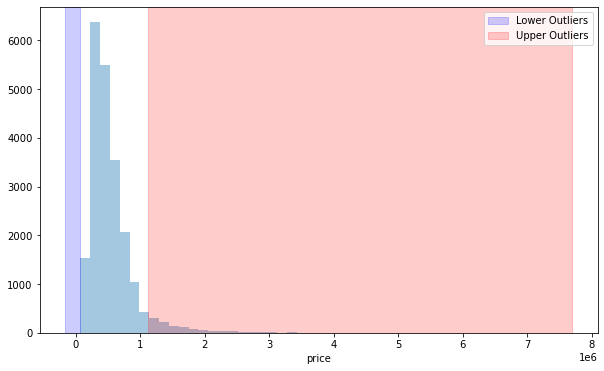

In [14]:
#plotting outliers graph for 'price' feature 
calc_interquartile(data, 'price')
plt.figure(figsize = (10,6))
sns.distplot(data['price'], kde=False)
print(upper, lower)
plt.axvspan(xmin = lower,xmax= data['price'].min(),alpha=0.2, color='blue', label='Lower Outliers')
plt.axvspan(xmin = upper,xmax= data['price'].max(),alpha=0.2, color='red', label='Upper Outliers')
plt.legend()
plt.show()

In [15]:
""" creating function for calculating zscore which is subtracting the mean from every data point and dividing by the standard deviation and if the zscore value of any data point 
is less than -3 or greater than 3, then that data point is an outlier"""

def z_score(data, column):
    #creating global variables for plotting the graph for better demonstration
    global zscore, outlier
    #creating lists to store zscore and outliers 
    zscore = []
    outlier =[]
    # for zscore generally taken thresholds are 2.5, 3 or 3.5 hence i took 3
    threshold = 3
    # calculating the mean of the passed column
    mean = np.mean(data[column])
    # calculating the standard deviation of the passed column
    std = np.std(data[column])
    for i in data[column]:
        z = (i-mean)/std
        zscore.append(z)
        #if the zscore is greater than threshold = 3 that means it is an outlier
        if np.abs(z) > threshold:
            outlier.append(i)
    return print('total outliers', len(outlier))

total outliers 406
1129575.0 -162625.0


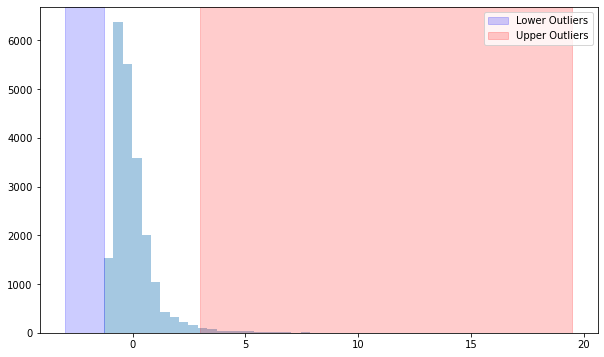

In [16]:
#plotting outliers graph for 'price' feature 
z_score(data, 'price')
plt.figure(figsize = (10,6))
sns.distplot(zscore, kde=False)
print(upper, lower)
plt.axvspan(xmin = -3 ,xmax= min(zscore),alpha=0.2, color='blue', label='Lower Outliers')
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red', label='Upper Outliers')
plt.legend()
plt.show()

In [17]:
#remove the outliers from price using zscore
dj=[]
for i in data.price:
    if i in set(outlier):
        dj.append(0.0)
    else:
        dj.append(i)
        
data['P'] = dj

x = data.drop(data[data['P'] == 0.0].index) 
x.shape

(21207, 18)

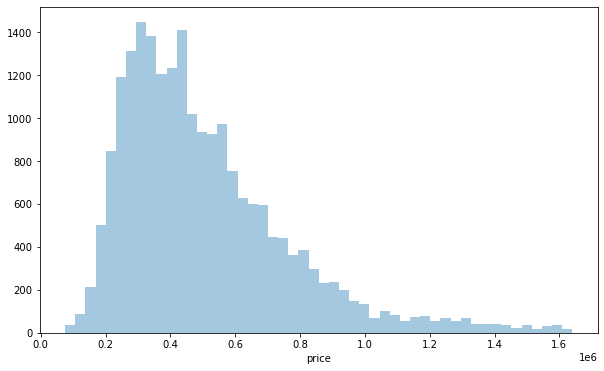

In [18]:
plt.figure(figsize = (10,6))
sns.distplot(x['price'], kde=False)
plt.show()

In [19]:
#defining the independent and dependent variable
X = x.drop(['price','P'], axis=1)
Y = x['price']

In [20]:
#removing the outliers using interquartile method
upper_outliers = data[data['price'] > upper]
upper_outliers

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age,P
5,1225000.0,4.0,4.50,101930.0,1.0,0.0,0.0,3.0,11.0,1530.0,98053.0,47.6561,-122.005,4760.0,101930.0,13.0,0.0,1225000.0
21,2000000.0,3.0,2.75,44867.0,1.0,0.0,4.0,3.0,9.0,720.0,98040.0,47.5316,-122.233,4110.0,20336.0,46.0,0.0,0.0
49,1350000.0,3.0,2.50,65005.0,1.0,1.0,2.0,5.0,9.0,588.0,98070.0,47.4041,-122.451,2680.0,72513.0,62.0,0.0,1350000.0
69,1325000.0,5.0,2.25,20158.0,1.0,0.0,0.0,3.0,8.0,1600.0,98004.0,47.6303,-122.215,3390.0,20158.0,49.0,0.0,1325000.0
125,1450000.0,4.0,2.75,17789.0,1.5,0.0,0.0,3.0,8.0,770.0,98004.0,47.6141,-122.212,3060.0,11275.0,101.0,78.0,1450000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21568,1700000.0,4.0,3.50,8963.0,2.0,0.0,0.0,3.0,10.0,710.0,98004.0,47.5990,-122.197,2190.0,10777.0,1.0,0.0,0.0
21576,3567000.0,5.0,4.50,10584.0,2.0,1.0,4.0,3.0,10.0,1310.0,98008.0,47.5943,-122.110,3470.0,18270.0,8.0,0.0,0.0
21590,1222500.0,4.0,3.50,9444.0,1.5,0.0,0.0,3.0,11.0,1800.0,98074.0,47.6502,-122.066,4560.0,11063.0,7.0,0.0,1222500.0
21597,1575000.0,4.0,3.25,10125.0,2.0,0.0,0.0,3.0,10.0,0.0,98040.0,47.5653,-122.223,2290.0,10125.0,8.0,0.0,1575000.0


In [21]:
x_ = data.drop(data[data['price']>upper].index)
x_

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age,P
0,221900.0,3.0,1.00,5650.0,1.0,0.0,0.0,3.0,7.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,59.0,0.0,221900.0
1,538000.0,3.0,2.25,7242.0,2.0,0.0,0.0,3.0,7.0,400.0,98125.0,47.7210,-122.319,1690.0,7639.0,63.0,40.0,538000.0
2,180000.0,2.0,1.00,10000.0,1.0,0.0,0.0,3.0,6.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,82.0,0.0,180000.0
3,604000.0,4.0,3.00,5000.0,1.0,0.0,0.0,5.0,7.0,910.0,98136.0,47.5208,-122.393,1360.0,5000.0,49.0,0.0,604000.0
4,510000.0,3.0,2.00,8080.0,1.0,0.0,0.0,3.0,8.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0,28.0,0.0,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3.0,2.50,1131.0,3.0,0.0,0.0,3.0,8.0,0.0,98103.0,47.6993,-122.346,1530.0,1509.0,5.0,0.0,360000.0
21609,400000.0,4.0,2.50,5813.0,2.0,0.0,0.0,3.0,8.0,0.0,98146.0,47.5107,-122.362,1830.0,7200.0,1.0,0.0,400000.0
21610,402101.0,2.0,0.75,1350.0,2.0,0.0,0.0,3.0,7.0,0.0,98144.0,47.5944,-122.299,1020.0,2007.0,5.0,0.0,402101.0
21611,400000.0,3.0,2.50,2388.0,2.0,0.0,0.0,3.0,8.0,0.0,98027.0,47.5345,-122.069,1410.0,1287.0,11.0,0.0,400000.0


In [22]:
y_ = x_['price']
x_ = x_.drop(['price','P'], axis=1)
y_

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 20467, dtype: float64

In [23]:
#isolation forest
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
outlier = iso.fit_predict(data)

In [24]:
#mask variable contains all the outliers
mask = outlier == -1
#task variable contains all the non-outliers data
task = outlier != -1
#creating dataframe containing outliers
df_1 = data[mask]
#creating dataframe containing non-outliers
df_2 = data[task]

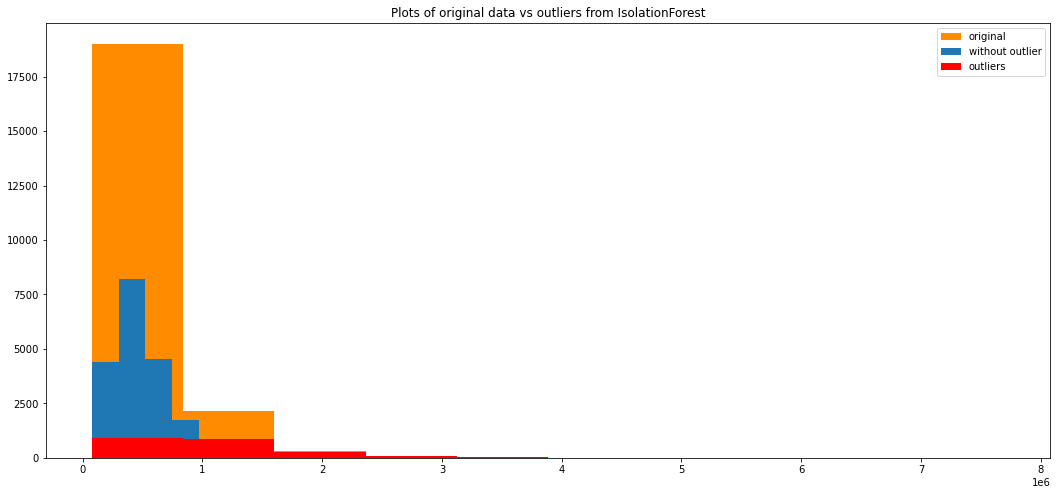

In [25]:
#plotting graph to show the original data, outliers and non-outliers 
plt.figure(figsize=(18, 8))
plt.title('Plots of original data vs outliers from IsolationForest')
plt.hist(data['price'], label= 'original', color='darkorange')
plt.hist(df_2['price'], label='without outlier')
plt.hist(df_1['price'], label='outliers', color='red')
plt.legend()
plt.show()

In [26]:
y2 = df_2['price']
df_2.drop(['price','P'], axis=1, inplace=True)

# training the data

In [27]:
#z_score one 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
r2_score(y_test, pred)

0.6917485447462964

In [28]:
#interquartile one 
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
r2_score(y_test, pred)

0.6726824810024188

In [29]:
#isolationforest 
x_train, x_test, y_train, y_test = train_test_split(df_2, y2, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
r2_score(y_test, pred)

0.6528616286630857

## So its clear that we should go with z_score one

In [29]:
#Hyperparameter tuning
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
kfold = KFold(n_splits=5)
results = cross_val_score(lr, x_train, y_train, cv=kfold)
results.mean()

0.6984617948957548

# Creating Pipeline to pass each models in it 

In [31]:
sc = ('Scaler', StandardScaler())
est =[]
est.append(('LinearRegression', Pipeline([sc, ('LinearRegression', LinearRegression())])))
est.append(('Ridge', Pipeline([sc, ('Ridge', Ridge())])))
est.append(('Lasso', Pipeline([sc, ('Lasso', Lasso())])))
est.append(('BayesianRidge', Pipeline([sc, ('BayesianRidge', BayesianRidge())])))
est.append(('ElasticNet', Pipeline([sc,('Elastic', ElasticNet())])))
est.append(('SGD', Pipeline([sc,('SGD', SGDRegressor())])))
est.append(('Huber', Pipeline([sc,('Huber', HuberRegressor())])))
est.append(('RANSAC', Pipeline([sc,('RANSAC', RANSACRegressor())])))
est.append(('GradientBoosting', Pipeline([sc,('GradientBoosting',GradientBoostingRegressor())])))
est.append(('AdaBoost', Pipeline([sc, ('AdaBoost', AdaBoostRegressor())])))
est.append(('ExtraTree', Pipeline([sc,('ExtraTrees', ExtraTreesRegressor())])))
est.append(('RandomForest', Pipeline([sc,('RandomForest', RandomForestRegressor())]))) 
est.append(('Bagging', Pipeline([sc,('Bagging', BaggingRegressor())])))
est.append(('KNeighbors', Pipeline([sc,('KNeighbors', KNeighborsRegressor())])))
est.append(('DecisionTree', Pipeline([sc,('DecisionTree', DecisionTreeRegressor())])))
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

In [32]:
import warnings
warnings.filterwarnings(action='ignore')
seed = 4
splits = 7
score = 'r2'
models_score =[]
for i in est:
    kfold = KFold(n_splits=splits, random_state=seed)
    results = cross_val_score(i[1], x_train, y_train, cv=kfold, scoring=score)
    models_score.append({i[0] : '{} +/- {}'.format(results.mean(), results.std())})

In [33]:
models_score

[{'LinearRegression': '0.6983386624440918 +/- 0.007174314027706037'},
 {'Ridge': '0.698338851049605 +/- 0.007174039165862322'},
 {'Lasso': '0.6983388078212428 +/- 0.007174073351645502'},
 {'BayesianRidge': '0.6983401859427667 +/- 0.0071715136603758495'},
 {'ElasticNet': '0.6539460679769464 +/- 0.008197842911207794'},
 {'SGD': '0.6967237284748211 +/- 0.00830243278560113'},
 {'Huber': '0.6903419273328895 +/- 0.005817857056917309'},
 {'RANSAC': '0.3828053744984256 +/- 0.22454692714230565'},
 {'GradientBoosting': '0.838440138603957 +/- 0.007157104414434751'},
 {'AdaBoost': '0.5641236451473463 +/- 0.019101281337209425'},
 {'ExtraTree': '0.8539331599579301 +/- 0.007653474085195275'},
 {'RandomForest': '0.8551692039567548 +/- 0.01013934344691937'},
 {'Bagging': '0.8411522162519555 +/- 0.01163922504382088'},
 {'KNeighbors': '0.771144647961164 +/- 0.009423807833768722'},
 {'DecisionTree': '0.7022347402921033 +/- 0.01257876954820298'},
 {'XGB': '0.8644931375784878 +/- 0.007808148622427609'}]

    ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor and XBGRegressor are best

### Hyperparameter Tuning

In [ ]:
#Tuning only XGB as it has the higher accuracy
est =[]
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

best = []

parameters = {
              
              'XGB': {'XGB__learning_rate': [0.1,0.2,0.3,0.4],
                         
                         'XGB__max_depth': [4,6,8],
                      'XGB__n_estimators': [100,500,1000,1500]}
             }

for i in est:
    kfold = KFold(n_splits=5, random_state=seed)
    grid = GridSearchCV(estimator=i[1], param_grid = parameters[i[0]], cv = kfold, n_jobs=-1)
    grid.fit(x_train, y_train)
    best.append((i[0], grid.best_score_,  grid.best_params_))

In [43]:
best

[('XGB',
  0.875338990859708,
  {'XGB__learning_rate': 0.1, 'XGB__max_depth': 4, 'XGB__n_estimators': 1000})]

In [32]:
#implementing it with best parameters
xgb = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=1000)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
xgb.score(x_test,y_test)

0.8733764163860631

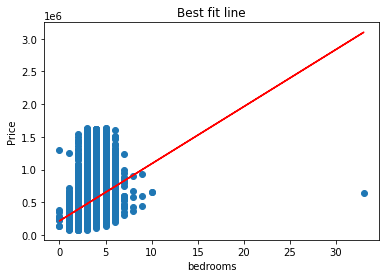

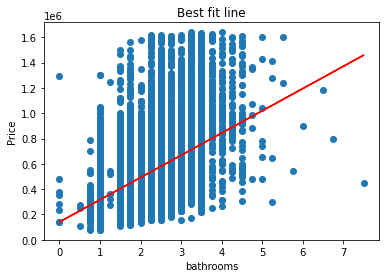

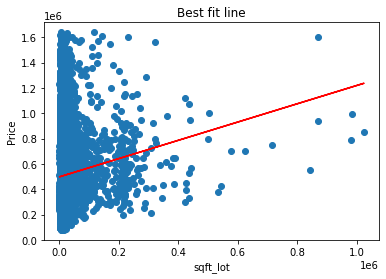

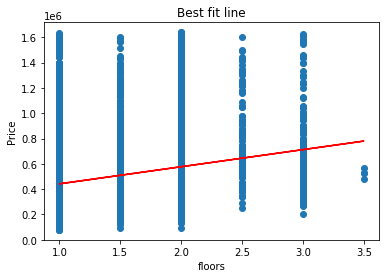

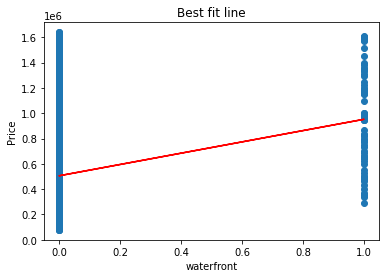

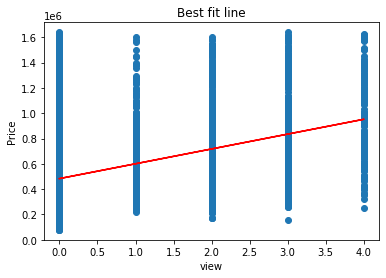

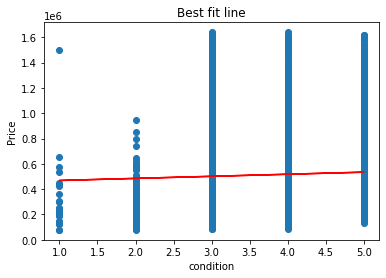

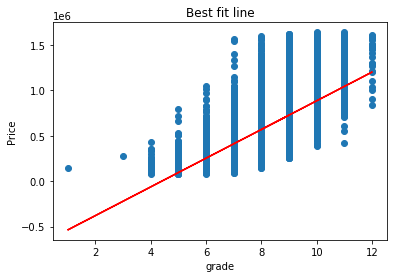

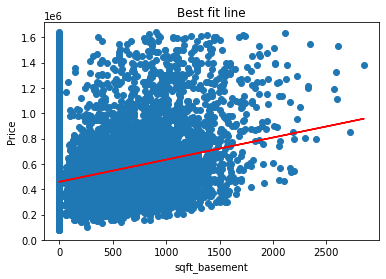

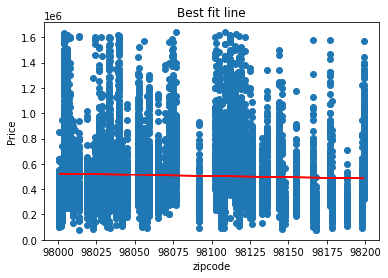

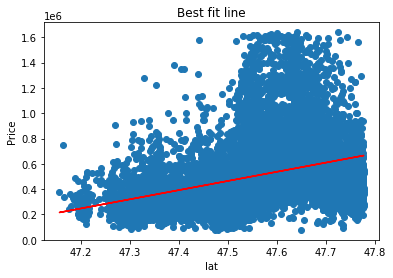

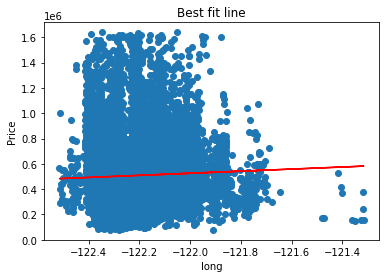

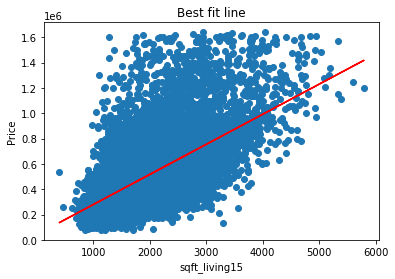

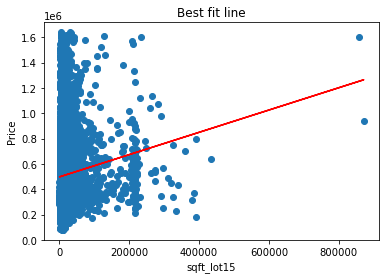

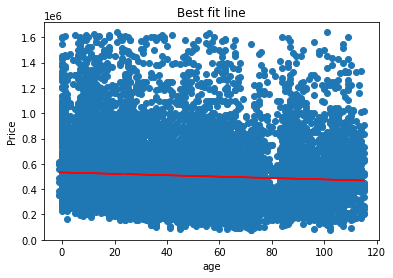

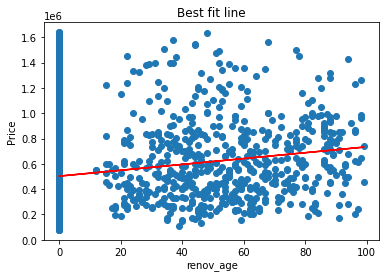

In [33]:
#plotting the regression line
for i,e in enumerate(x_train.columns):
    lr.fit(x_train[e].values[:,np.newaxis], y_train.values)
    plt.title("Best fit line")
    plt.xlabel(str(e))
    plt.ylabel('Price')
    plt.scatter(x_train[e].values[:,np.newaxis], y_train)
    plt.plot(x_train[e].values[:,np.newaxis], lr.predict(x_train[e].values[:,np.newaxis]),color='r')
    plt.show()

In [ ]:
for i,e in enumerate(x_train.columns):
    lr.fit(x_train[e].values[:,np.newaxis], y_train.values)
    plt.title("Best fit line")
    plt.xlabel(str(e))
    plt.ylabel('Price')
    plt.scatter(x_train[e].values[:,np.newaxis], y_train)
    plt.plot(x_train[e].values[:,np.newaxis], lr.predict(x_train[e].values[:,np.newaxis]),color='r')
    plt.show()

# Hence XGB is the best model for this problem

# END OF NOTEBOOK

I am applying neural network just for practise

# Applying Neural Networks

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [52]:
def base_model():
    model = Sequential()
    model.add(Dense(16, input_dim=16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [53]:
estimator = KerasRegressor(build_fn=base_model, epochs=100, batch_size= 5)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
results.mean()

Epoch 1/100
2672/2672 [==============================] - 4s 1ms/step - loss: 101113143296.0000
Epoch 2/100
2672/2672 [==============================] - 4s 1ms/step - loss: 64812027904.0000
Epoch 3/100
2672/2672 [==============================] - 4s 1ms/step - loss: 63435202560.0000
Epoch 4/100
2672/2672 [==============================] - 4s 1ms/step - loss: 61628891136.0000
Epoch 5/100
2672/2672 [==============================] - 4s 1ms/step - loss: 59545657344.0000
Epoch 6/100
2672/2672 [==============================] - 4s 1ms/step - loss: 57220431872.0000
Epoch 7/100
2672/2672 [==============================] - 4s 1ms/step - loss: 54923108352.0000
Epoch 8/100
2672/2672 [==============================] - 4s 1ms/step - loss: 52492197888.0000
Epoch 9/100
2672/2672 [==============================] - 4s 1ms/step - loss: 50343534592.0000
Epoch 10/100
2672/2672 [==============================] - 4s 1ms/step - loss: 47891030016.0000
Epoch 11/100
2672/2672 [==============================] - 

2672/2672 [==============================] - 4s 1ms/step - loss: 39886123008.0000
Epoch 88/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40054677504.0000
Epoch 89/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39904780288.0000
Epoch 90/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39819345920.0000
Epoch 91/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39941496832.0000
Epoch 92/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39886139392.0000
Epoch 93/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39858397184.0000
Epoch 94/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39796244480.0000
Epoch 95/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39878823936.0000
Epoch 96/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39821373440.0000
Epoch 97/100
2672/2672 [==============================] - 4s 1m

2672/2672 [==============================] - 4s 1ms/step - loss: 40307998720.0000
Epoch 73/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40461770752.0000
Epoch 74/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40412598272.0000
Epoch 75/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40417300480.0000
Epoch 76/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40403922944.0000
Epoch 77/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40354664448.0000
Epoch 78/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40436449280.0000
Epoch 79/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40357986304.0000
Epoch 80/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40334516224.0000
Epoch 81/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40331481088.0000
Epoch 82/100
2672/2672 [==============================] - 4s 2m

2672/2672 [==============================] - 4s 1ms/step - loss: 40616513536.0000
Epoch 58/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40611913728.0000
Epoch 59/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40599953408.0000
Epoch 60/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40580837376.0000
Epoch 61/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40583540736.0000
Epoch 62/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40552497152.0000
Epoch 63/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40494403584.0000
Epoch 64/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40558481408.0000
Epoch 65/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40538120192.0000
Epoch 66/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40510656512.0000
Epoch 67/100
2672/2672 [==============================] - 4s 1m

2672/2672 [==============================] - 4s 1ms/step - loss: 40636850176.0000
Epoch 43/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40554106880.0000
Epoch 44/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40739573760.0000
Epoch 45/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40531337216.0000
Epoch 46/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40670568448.0000
Epoch 47/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40536473600.0000
Epoch 48/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40455725056.0000
Epoch 49/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40501321728.0000
Epoch 50/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40353550336.0000
Epoch 51/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40454447104.0000
Epoch 52/100
2672/2672 [==============================] - 4s 1m

2672/2672 [==============================] - 3s 1ms/step - loss: 39549779968.0000
Epoch 28/100
2672/2672 [==============================] - 3s 1ms/step - loss: 39358418944.0000
Epoch 29/100
2672/2672 [==============================] - 3s 1ms/step - loss: 39216123904.0000
Epoch 30/100
2672/2672 [==============================] - 3s 1ms/step - loss: 39131627520.0000
Epoch 31/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39092658176.0000
Epoch 32/100
2672/2672 [==============================] - 3s 1ms/step - loss: 38932283392.0000
Epoch 33/100
2672/2672 [==============================] - 3s 1ms/step - loss: 38888304640.0000
Epoch 34/100
2672/2672 [==============================] - 3s 1ms/step - loss: 38766624768.0000
Epoch 35/100
2672/2672 [==============================] - 3s 1ms/step - loss: 38703722496.0000
Epoch 36/100
2672/2672 [==============================] - 3s 1ms/step - loss: 38673948672.0000
Epoch 37/100
2672/2672 [==============================] - 3s 1m

2672/2672 [==============================] - 3s 1ms/step - loss: 42782527488.0000
Epoch 13/100
2672/2672 [==============================] - 3s 1ms/step - loss: 42131943424.0000
Epoch 14/100
2672/2672 [==============================] - 3s 1ms/step - loss: 41861599232.0000
Epoch 15/100
2672/2672 [==============================] - 3s 1ms/step - loss: 41509076992.0000
Epoch 16/100
2672/2672 [==============================] - 3s 1ms/step - loss: 41390301184.0000
Epoch 17/100
2672/2672 [==============================] - 3s 1ms/step - loss: 41194659840.0000
Epoch 18/100
2672/2672 [==============================] - 3s 1ms/step - loss: 41119985664.0000
Epoch 19/100
2672/2672 [==============================] - 3s 1ms/step - loss: 41065791488.0000
Epoch 20/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40993521664.0000
Epoch 21/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40951898112.0000
Epoch 22/100
2672/2672 [==============================] - 3s 1m

2672/2672 [==============================] - 4s 1ms/step - loss: 39700828160.0000
Epoch 99/100
2672/2672 [==============================] - 4s 1ms/step - loss: 39737782272.0000
Epoch 100/100
297/297 [==============================] - 0s 1ms/step - loss: 42656260096.0000
Epoch 1/100
2672/2672 [==============================] - 4s 1ms/step - loss: 97535762432.0000
Epoch 2/100
2672/2672 [==============================] - 4s 1ms/step - loss: 65476591616.0000
Epoch 3/100
2672/2672 [==============================] - 4s 1ms/step - loss: 63917821952.0000
Epoch 4/100
2672/2672 [==============================] - 4s 1ms/step - loss: 62086041600.0000
Epoch 5/100
2672/2672 [==============================] - 4s 1ms/step - loss: 59962015744.0000
Epoch 6/100
2672/2672 [==============================] - 3s 1ms/step - loss: 57505083392.0000
Epoch 7/100
2672/2672 [==============================] - 4s 1ms/step - loss: 54837432320.0000
Epoch 8/100
2672/2672 [==============================] - 3s 1ms/step - 

2672/2672 [==============================] - 4s 2ms/step - loss: 37826191360.0000
Epoch 84/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37916381184.0000
Epoch 85/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37780381696.0000
Epoch 86/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37684183040.0000
Epoch 87/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37713854464.0000A: 0s - loss: 3
Epoch 88/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37682147328.0000
Epoch 89/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37714984960.0000
Epoch 90/100
2672/2672 [==============================] - 4s 2ms/step - loss: 37681303552.0000
Epoch 91/100
2672/2672 [==============================] - 4s 2ms/step - loss: 37623390208.0000
Epoch 92/100
2672/2672 [==============================] - 4s 2ms/step - loss: 37601153024.0000
Epoch 93/100
2672/2672 [========================

2672/2672 [==============================] - 4s 1ms/step - loss: 40214351872.0000
Epoch 69/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40246292480.0000
Epoch 70/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40161837056.0000
Epoch 71/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40195485696.0000
Epoch 72/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40135098368.0000
Epoch 73/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40200011776.0000
Epoch 74/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40090710016.0000
Epoch 75/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40119377920.0000
Epoch 76/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40196341760.0000
Epoch 77/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40179408896.0000
Epoch 78/100
2672/2672 [==============================] - 4s 1m

2672/2672 [==============================] - 3s 1ms/step - loss: 37293989888.0000
Epoch 54/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37312270336.0000
Epoch 55/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37235200000.0000
Epoch 56/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37182644224.0000
Epoch 57/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37170221056.0000
Epoch 58/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37119188992.0000
Epoch 59/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37017169920.0000
Epoch 60/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37000114176.0000
Epoch 61/100
2672/2672 [==============================] - 4s 1ms/step - loss: 37020893184.0000
Epoch 62/100
2672/2672 [==============================] - 3s 1ms/step - loss: 36986200064.0000
Epoch 63/100
2672/2672 [==============================] - 4s 1m

2672/2672 [==============================] - 3s 1ms/step - loss: 40518037504.0000
Epoch 39/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40539697152.0000
Epoch 40/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40472895488.0000
Epoch 41/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40469331968.0000
Epoch 42/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40399728640.0000
Epoch 43/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40455839744.0000
Epoch 44/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40421322752.0000
Epoch 45/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40372609024.0000
Epoch 46/100
2672/2672 [==============================] - 4s 1ms/step - loss: 40383365120.0000
Epoch 47/100
2672/2672 [==============================] - 3s 1ms/step - loss: 40385384448.0000
Epoch 48/100
2672/2672 [==============================] - 4s 1m

-38739739443.2

In [59]:
results.mean()

-38739739443.2

In [62]:
estimator.fit(x_train, y_train)
r2_score(y_test, estimator.predict(x_test))

Epoch 1/100
2969/2969 [==============================] - 4s 1ms/step - loss: 96390643712.0000
Epoch 2/100
2969/2969 [==============================] - 4s 1ms/step - loss: 64134987776.0000
Epoch 3/100
2969/2969 [==============================] - 4s 1ms/step - loss: 62021939200.0000
Epoch 4/100
2969/2969 [==============================] - 4s 1ms/step - loss: 59300282368.0000
Epoch 5/100
2969/2969 [==============================] - 4s 1ms/step - loss: 56084283392.0000
Epoch 6/100
2969/2969 [==============================] - 4s 1ms/step - loss: 52618436608.0000
Epoch 7/100
2969/2969 [==============================] - 4s 1ms/step - loss: 49529131008.0000
Epoch 8/100
2969/2969 [==============================] - 4s 1ms/step - loss: 47053733888.0000
Epoch 9/100
2969/2969 [==============================] - 4s 1ms/step - loss: 45160697856.0000
Epoch 10/100
2969/2969 [==============================] - 4s 1ms/step - loss: 43814731776.0000
Epoch 11/100
2969/2969 [==============================] - 4

2969/2969 [==============================] - 4s 1ms/step - loss: 40013701120.0000
Epoch 88/100
2969/2969 [==============================] - 4s 1ms/step - loss: 40028573696.0000
Epoch 89/100
2969/2969 [==============================] - 4s 1ms/step - loss: 40059432960.0000
Epoch 90/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39984340992.0000
Epoch 91/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39924031488.0000
Epoch 92/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39945691136.0000
Epoch 93/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39913197568.0000
Epoch 94/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39892533248.0000
Epoch 95/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39860219904.0000
Epoch 96/100
2969/2969 [==============================] - 4s 1ms/step - loss: 39975170048.0000
Epoch 97/100
2969/2969 [==============================] - 4s 1m

0.3950333330994076

In [63]:
r2_score(y_test, estimator.predict(x_test))

0.3950333330994076

Definitely not a neural network